In [1]:
import cartopy.crs as ccrs 
import cartopy.feature as cfeature
from metpy.plots import USCOUNTIES
from metpy.plots import  StationPlot

import datetime as dt
import matplotlib.pyplot as plt


from netCDF4 import num2date
import numpy as np
import glob
import SNmods as snmods

# IMPORTANT
from info import probe_locs, savedir

import pandas as pd
from functions import calc_dewpoint,calc_thetae,calc_thetav,C_to_F,calc_mslp,convert_wind, parse_currtime
from functions_plotting import scale_bar, plot_logo
from collections import OrderedDict

# # read in cartopy information    
crs = ccrs.PlateCarree()
# Get data to plot state and province boundaries
states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lakes',
        scale='10m',
        facecolor='none')


%config InlineBackend.figure_format='retina'


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [2]:

analysis_time = dt.datetime(2017,4,30,23,9)
starttime = endtime = analysis_time


data_df = snmods.get_sticknet_data(starttime-dt.timedelta(hours=24),endtime, 
                                                                  dataset='subset',probes=['0102A', '0103A'],
                                                                 plotmeteograms=True, returndata=True)

0102A


/Users/jessmcd/miniconda3/envs/py3_cart/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/Users/jessmcd/miniconda3/envs/py3_cart/lib/python3.7/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/Users/jessmcd/miniconda3/envs/py3_cart/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


0103A


In [13]:
np.ceil((dates[-1]-dates[0]).seconds/(60*60) + (dates[-1]-dates[0]).days*24)

24.0

In [2]:
# get vse data for testint




################### Inputs that are changed in testing #######################
# Hard coded StesoNet locations in another python file (can change the year)
# probe_locs = probe_info.probe_locs_2019

# File directory where the realtime text files are located
# filedir = '/Users/severe/Research/VORTEXSE/RT_files/'

# # Filepath(s) to write tabular data for online display
# html_filepath = '/Users/severe/Research/VORTEXSE/data.csv'
# noaa_filepath = '/Users/severe/Research/VORTEXSE/data_noaa.csv'


# Set the starttime and endtime for plotting
# 24 hours for meteograms, less than that for objective analysis or grid plots
#endtime      = dt.datetime(2016,3,31,23,59,0,0)         # for testing
# endtime      = dt.datetime.utcnow()
# starttime    = endtime - dt.timedelta(hours=24)

##############################################################################



analysis_time = dt.datetime(2017,4,30,19,9)
starttime = endtime = analysis_time


# open (create) html file for writing
# html_file = open(html_filepath,'w')

# Grab the data from files in filedir we want to plot
# probe ID, date, pressure, temperature, wind speed, wind direction, relative humidity,
probes = list(probe_locs.keys())
data_df = snmods.get_sticknet_data(starttime,endtime, dataset='latest',probes=probes)#,html=html_file)

if not data_df.empty:

    #data_df = data_df.loc[['0102A', '0106A', '0107A', '0217A', '0215A', '0109A']]


    lats =       data_df['Lat'].values
    lons =       data_df['Lon'].values
    elevations = data_df['Elevation'].values
    IDs =        [ids[1:] for ids in data_df.index.values]

    dew_plot = calc_dewpoint(data_df['T'].values,data_df['RH'].values)
    mslp = calc_mslp(data_df['T'].values, data_df['P'].values, elevations)
    u,v = convert_wind(data_df['WS'].values,data_df['WD'].values)

    obtime = data_df['date'][0]


/Users/jessmcd/miniconda3/envs/py3_cart/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0102A
0103A
0104A
0105A
0106A
0107A
0108A
0109A
0110A
0111A
0112A
0213A
0214A
0215A
0216A
0217A


In [2]:
## get meso18-19 data for testing

def get_stesonet(time):
    ''' 
    Returns all available sticknets at a give time.
    -------------
    INPUT: a datetime object specifying the time of interest
    OUTPUT: a pandas dataframe containing all available sticknet data.
    -------------
    Note: manually edit datadir.
    Note: "3secmax" is the maximum mean 3-second wind gust.
    '''
    date = time.strftime('%Y%m%d')
    datadir = r'/Users/jessmcd/Documents/MyPassport_backup/Meso18_19/dailyfiles/daily_files_1min_mean/*_{}.txt'.format(date)
    files = sorted(glob.glob(datadir), key=lambda f: f[-18:-13]) # put files in order by SN ID

    # initialize empy dataframes/arrays
    df = pd.DataFrame(data={})
    ids=[]
    
    # loop over all files
    for f in files:
        data = pd.read_csv(f, header=0, names=['time','T','RH','P','WS','3secmax','WD','batt','tflag','wflag'],
                      dtype={'time':np.str}, index_col=0, infer_datetime_format=True)
        data.index = pd.to_datetime(data.index)
        try:
            temp = data.loc[time]

            if temp.empty != True:
                temp.drop(labels=['3secmax', 'batt', 'tflag', 'wflag'], inplace=True)
                df = df.append(temp)
                ids.append(f[-18:-13])
        except KeyError:
            continue
    
    # set index to be IDs since we already know what time it should be
    df.index = ids
    df.insert(0, "probe", ids, True)
    
    print('Found {} StickNets'.format(len(ids)))
    return df

probe_locs = probe_info.probe_locs_2019 


# scary cuz dicts aren't ordered, but this has never NOT read them in properly...  
lats = np.asarray(list(zip(*(list(zip(*probe_locs.items()))[1])))[0])
lons = np.asarray(list(zip(*(list(zip(*probe_locs.items()))[1])))[1])
elevations = np.asarray(list(zip(*(list(zip(*probe_locs.items()))[1])))[2])
IDs = np.asarray(list(zip(*(list(zip(*probe_locs.items()))[1])))[3])

date = dt.datetime(2019,3,14,23,50)
data_df = get_stesonet(date)

# sub = ['0221A', '0107A', '0223A', '0214A', '0106A']
# data_df= data_df.loc[sub]

# lats,lons, elevations, IDs = [],[],[],[]
# for count,loc in enumerate(data_df['probe']):
#     lats.append(probe_locs[loc][0])
#     lons.append(probe_locs[loc][1])
#     elevations.append(probe_locs[loc][2])
#     IDs.append(probe_locs[loc][3])


obtime = date#data_df['dates'][0]

dew_plot = calc_dewpoint(data_df['T'].values,data_df['RH'].values)
mslp = calc_mslp(data_df['T'].values, data_df['P'].values, np.asarray(elevations))
u,v = convert_wind(data_df['WS'].values,data_df['WD'].values)

Found 24 StickNets


## Plot code

/Users/jessmcd/miniconda3/envs/py3_cart/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/Users/jessmcd/miniconda3/envs/py3_cart/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in greater


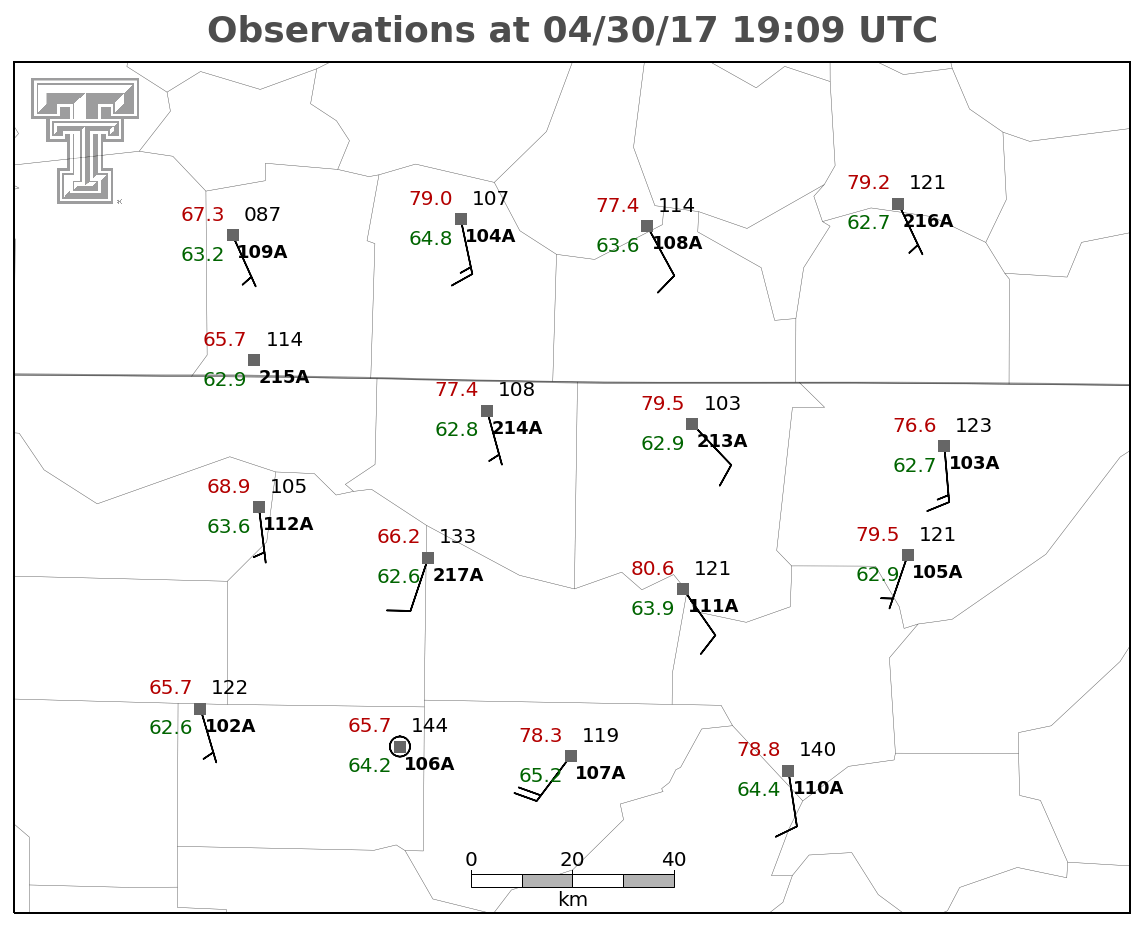

In [3]:



### find extent of plot
# exact center of plot
clat = np.amin(lats)+ abs(np.amax(lats) - np.amin(lats))/2
clon = np.amin(lons) + abs(np.amin(lons) - np.amax(lons))/2

# NOTE: change these hardcoded values if you want to change relative domain size
# larger (smaller) numbers = larger (smaller) domain
dlat = 0.75 * abs(np.amax(lats) - np.amin(lats))
dlon = 0.75 * abs(np.amin(lons) - np.amax(lons))

if dlon < .1:
    dlon = .1
if dlat < .1:
    dlat = .1

# find corners using the center and the buffers
north_lat, south_lat = clat+dlat, clat-dlat
west_lon, east_lon = clon-dlon, clon+dlon


### initialize figure
fig = plt.figure(figsize = [10,10])
ax = fig.add_subplot(1,1,1, projection=crs)
ax.set_extent([west_lon, east_lon, north_lat,south_lat], crs )
ax.add_feature(states_provinces, edgecolor='k', alpha=0.25, linewidth=1)
ax.add_feature(USCOUNTIES.with_scale('20m'), alpha=0.4, linewidth=0.2)

# mark locations of SN
ax.plot(lons,lats,marker='s',color='0.4',markersize=5, linewidth=0)

# use metpy to plot T, Td, MSLP (coded), and the 4-letter identifiers
stationplot = StationPlot(ax, lons, lats,clip_on=True, transform=crs, fontsize=10)
stationplot.plot_parameter((-1.5,1), C_to_F(data_df['T'].values), color='#b30000', formatter='0.1f')
stationplot.plot_parameter((-1.5,-1), C_to_F(dew_plot), color='darkgreen', formatter='0.1f')
stationplot.plot_parameter((1.5,1), mslp, formatter=lambda v: format(10 * v, '.0f')[-3:])
stationplot.plot_text((1.5, -.9), IDs, fontsize=9, weight='bold')

# Add wind barbs, dropping bad vals, cuz WS can == -999
u[abs(u)>60] = 0; v[abs(v)>60] = 0
ax.barbs(lons, lats, u, v, length=7.5,sizes={'emptybarb':.18}, lw=0.8)
                

### title
ax.set_title('Observations at {}'.format(obtime.strftime('%D %H:%M UTC')),
             fontsize=18, y=1.01, weight='bold', color='0.3')

### Plot the TTU logo, have it update location based on shape of base map
plot_logo(fig, ax)


### Scale Bar
# find appropriate lenght of scale bar
# should be ~ 1/5th the width of the plot
# use 1 deg lon -> 111km approximation (10*10)
center = np.average([ax.get_position().x0, ax.get_position().x1])
#scale_len = np.ceil((abs(np.amin(lons) - np.amax(lons))*10)/4)*10

scale_len = np.ceil((dlon*10)/3.5)*10

if scale_len < 10:
    scale_len = 10
    

scale_bar(fig, ax, length=int(scale_len), location=(center, ax.get_position().y0))
#ax.text(center, 0.01, 'km', ha='center',fontsize=10, transform=ax.transAxes)

# save figure 
# savedir = 'RT_tests' # hard coded real time directory
# nametime = parse_currtime()[1] # note that this may be different from last time on plot
#                              # THATS OKAY... it will make data drops more apparent!
# plt.savefig('{0}/{1}_oban_{2}.png'.format(savedir,name,nametime),dpi=300,bbox_inches = 'tight')
# plt.close()


plt.show()


In [28]:
import matplotlib.patches as patches

In [37]:
def scale_bar(fig, ax, length=None, location=(0.5, 0.05),N=4,
              height=1, fontsize=12, text_pad=2.5, edge_width=0.5,
              edge_color='k', text_color='k', color1='w', color2='0.7', 
              unit_label='km', top=True, ticks=True, tick_len=1):
    """
    Adds a scale bar to cartopy plots. Only use even numbers for length!
   
    INPUTS:
        fig         - the matplotlib figure, for sizing the scale bar appropriately
        ax          - the axis object to draw the scalebar on.
        length      - the length of the scalebar in km. Only use even numbers!
        location    - (x,y) the center of the scalebar in *axis coordinates*
                      (ie. 0.5 is the middle of the plot)
        N           - The number of alternating bars. Only works for even numbers!
        height      - the height of the scalebar (default=1)
        fontsize    - the size of the text
        text_pad    - controls the spacing between the text and the scale bar (default=2.5)
        edge_width  - the width of the scale bar edge
        edge_color  - the color of the edge (default='k')
        text_color  - the color of the text (default='k')
        color1      - the first alternating color of the scale (default='w')
        color2      - the second alternating color of the scale (default='0.7')
        unit_label  - adds unit to the scale. Set to '' if you don't want it (default='km')
        top         - if True, numbers are located above the scale, otherwise they are below (default=True)
        ticks       - if True, adds ticks in line with the numbers (default=True)
        tick_len    - the length of the ticks, valid only if ticks=True (default=1)

    Edited by J. McDonald 2021. Based on GitHub - https://github.com/SciTools/cartopy/issues/490
    """

    #Get the limits of the axis in lat long
    llx0, llx1, lly0, lly1 = ax.get_extent(ccrs.PlateCarree())
    #Make Transverse Mercator proj (tmc) horizontally centered on the middle of the map,
    #vertically at scale bar location
    sbllx = (llx1 + llx0) / 2
    sblly = lly0 + (lly1 - lly0) * location[1]  
    tmc = ccrs.TransverseMercator(sbllx, sblly)
    
    #Get the extent of the plotted area in coordinates in metres
    x0, x1, y0, y1 = ax.get_extent(tmc)

    # if no length added, make scale ~1/5th of the plot width
    if length == None: 
        length= (int((x1 - x0)*.2/1000)- (int((x1 - x0)*.2/1000)%10))*1000 # m

    # get the width in ax-relative coords, then convert to fig-relative coords
    ax_width = length/(x1 - x0)
    fig_width = ax_width*(ax.get_position().x1-ax.get_position().x0)

    print(ax_width, fig_width)

    # add new axes of the correct width (the same as the length desired)
    ax2 = fig.add_axes([location[0]-fig_width/2, location[1] ,fig_width,.25], zorder=10)
    ax2.set_xlim(0,1)
    ax2.axis('off')

    # horizontal center of scale within ax2, keeps numbers from touching bottom when
    # using ax.get_position().y0 for the y location
    y = .13 
    fc = [color1, color2]

    # add in the alternating colors, (x,y), width, height
    for i in np.arange(0, N, 1):
        r = patches.Rectangle((i/N  , y-.035*height/2), 1/N, .035*height, lw=edge_width,ec=edge_color, 
                              fc=fc[i%2], transform=ax2.transAxes, clip_on=False)
        ax2.add_patch(r)


    buffer = .035*height / 2

    # if ticks, let tick height > scale width
    tick_h = 1
    if not ticks: tick_h = 0; tick_len=0

    # put numbers on top of scale
    # the units have a "tick_len" adjustment, so that changing the text_pad for longer
    # tick_lens won't result in a unit spacing that's stupidly large
    if top: 

        ticks_sign = 1
        ax2.text(0.5, y-buffer-text_pad/100-.01+tick_len/100,'km', transform=ax2.transAxes,
                            ha ='center', va='top', color=text_color, fontsize=fontsize)

        for i in np.arange(0, N-1, 1):
            ax2.text(i/2, y+buffer+text_pad/100 , str(int((i/2000)*length)), transform=ax2.transAxes,
                            ha ='center', va='bottom', color=text_color, fontsize=fontsize)
            # ticks
            ax2.plot([i/2, i/2],[y, y+(.035*height*tick_len)*tick_h], lw=edge_width, 
                     c=edge_color,transform=ax2.transAxes, clip_on=False)

    # put numbers on mottom of scale    
    if not top: 
        ticks_sign = -1
        # km
        ax2.text(0.5, y+buffer+text_pad/100-tick_len/100,'km', transform=ax2.transAxes,
                            ha ='center', va='bottom', color=text_color, fontsize=fontsize)

        for i in np.arange(0, N-1, 1):
            ax2.text(i/2, y-buffer-text_pad/100-0.01 , str(int((i/2000)*length)), transform=ax2.transAxes,
                            ha ='center', va='top', color=text_color, fontsize=fontsize)
             # ticks
            ax2.plot([i/2, i/2],[y, y-(.035*height*tick_len)*tick_h], lw=edge_width, 
                     c=edge_color,transform=ax2.transAxes, clip_on=False)

# prepping the radar locations csv

In [95]:
df = pd.read_csv('RadarLocs.csv', names = ['WBAN', 'ID','CITY', 'LOC', 'ELEV_ft', 'HEIGHT_m'], skiprows=1)
df.drop(columns=['WBAN', 'HEIGHT_m'], inplace=True)

df['LAT'] = np.nan
df['LON'] = np.nan

for i in df.index:
    lat = (df.loc[i]['LOC'].split('/')[0]).replace(' ', '')
    latitude = int(lat[0:2]) + int(lat[2:4])/60 + int(lat[4:])/3600

    df.loc[i, 'LAT'] = np.round(latitude,4)
    
    lon = (df.loc[i]['LOC'].split('/')[1]).replace(' ', '')
    longitude =  -1* ( int(lon[0:3]) + int(lon[3:5])/60 + int(lon[5:7])/3600)

    df.loc[i, 'LON'] = np.round(longitude,4)

df.drop(columns=['LOC'], inplace=True)
df = df[['ID', 'LAT', 'LON', 'CITY', 'ELEV_ft']]

df.to_csv('NEXRAD_Radar_Locations.csv', index=False)

In [97]:
RadarLocs

ID      LAT       LON                CITY  ELEV_ft
0    KABR  45.4558  -98.4131        Aberdeen, SD     1302
1    KENX  42.5864  -74.0639          Albany, NY     1826
2    KABX  35.1497 -106.8239     Albuquerque, NM     5870
3    KFDR  34.3622  -98.9764       Altus AFB, OK     1267
4    KAMA  35.2333 -101.7092        Amarillo, TX     3587
..    ...      ...       ...                 ...      ...
153  KVNX  36.7408  -98.1278       Vance AFB, OK     1210
154  KVBX  34.8381 -120.3969  Vandenberg AFB, CA     1223
155  KICT  37.6547  -97.4428         Wichita, KS     1335
156  KLTX  33.9894  -78.4289      Wilmington, NC       64
157  KYUX  32.4953 -114.6567            Yuma, AZ      174

[158 rows x 5 columns]

In [115]:
clat = np.amin(lats)+ abs(np.amax(lats) - np.amin(lats))/2
clon = np.amin(lons) + abs(np.amin(lons) - np.amax(lons))/2
get_Radar(clat, clon)

('KHTX', 'Huntsville, AL')

In [114]:
# find closest radar
def get_Radar(lat, lon):
    
    ''' 
    Lat and lon are the location of the center of your domain (average sticknet loc?). 
    Returns the 4-letter identifier (e.g., 'KHTX' for hytop) needed to get radar data using AWS, 
    and the name of the city that the radar is located in for a sanity check.
    '''
    
    RadarLocs = pd.read_csv('NEXRAD_Radar_Locations.csv')

    dx = (lon-RadarLocs['LON'])*40000*np.cos((lat+RadarLocs['LAT'])*np.pi/360)/360
    dy = (lat-RadarLocs['LAT'])*40000/360
    ds = np.sqrt(dx**2+dy**2) # km
    
    return  RadarLocs.iloc[np.argmin(ds)]['ID'], RadarLocs.iloc[np.argmin(ds)]['CITY']

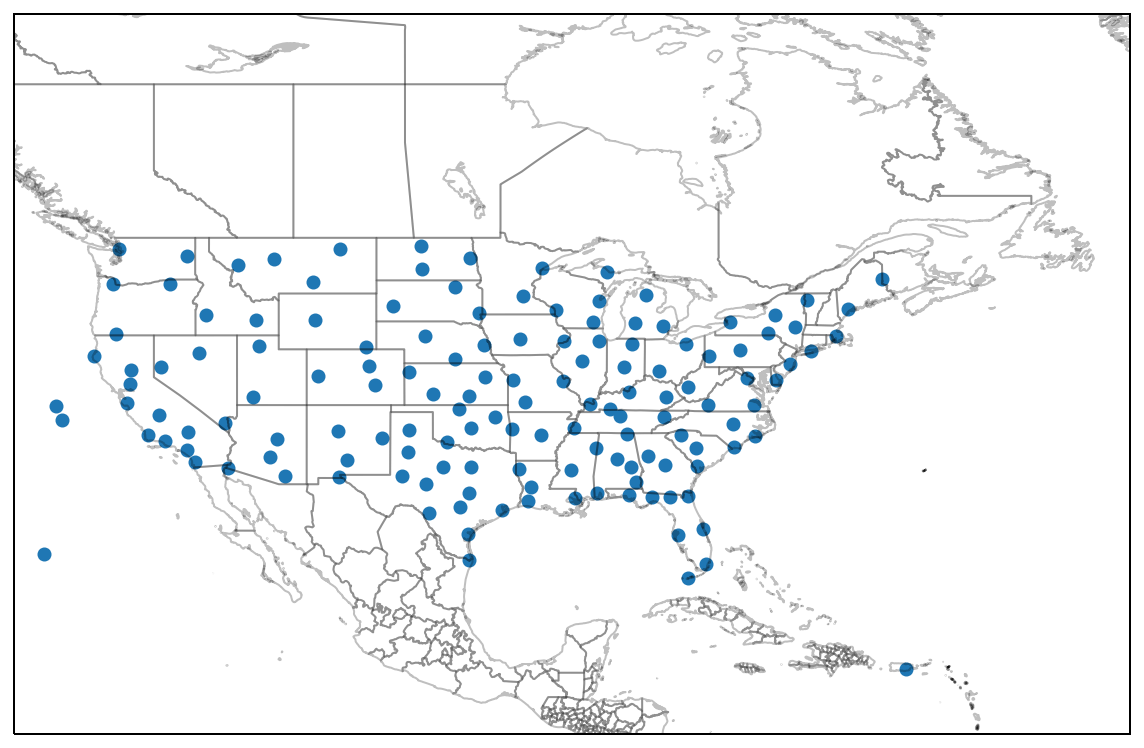

In [80]:
# find corners using the center and the buffers
north_lat, south_lat = df['lat'].max(), df['lat'].min()
west_lon, east_lon = -130, -50


### initialize figure
fig = plt.figure(figsize = [10,10])
ax = fig.add_subplot(1,1,1, projection=crs)
ax.set_extent([west_lon, east_lon, north_lat,south_lat], crs )
ax.add_feature(states_provinces, edgecolor='k', alpha=0.25, linewidth=1)
#ax.add_feature(USCOUNTIES.with_scale('20m'), alpha=0.4, linewidth=0.2)

ax.scatter(df['lon'], df['lat'])

In [44]:
df.loc[i]['LOC']

'132709 / 1444841E'